In [4]:
URL = 'https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/main/chapter11/jesterfinal151cols.csv'

In [6]:
import pandas as pd
jester_data = pd.read_csv(URL, header=None)

In [7]:
jester_data.index.name = "users"

In [10]:
for col in jester_data.columns:
    jester_data[col] = jester_data[col].apply(lambda x: 0.0 if x>=99 or x<7.0 else 1.0)

In [11]:
jester_data = jester_data[jester_data.sum(axis=1) > 0]

In [12]:
jester_data.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
users,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from mab_ranking.bandits.rank_bandits import IndependentBandits
from mab_ranking.bandits.bandits import DirichletThompsonSampling

In [14]:
independent_bandits = IndependentBandits(
    num_arms = jester_data.shape[1],
    num_ranks = 10,
    bandit_class = DirichletThompsonSampling
)

In [15]:
from tqdm import trange
num_steps = 7000
hit_rates = []
for _ in trange(1, num_steps+1):
    selected_items = set(independent_bandits.choose())
    # Pick a user choices at random
    random_user = jester_data.sample().iloc[0, :]
    ground_truth = set(random_user[random_user == 1].index)
    hit_rate = len(ground_truth.intersection(selected_items)) / len(ground_truth)
    feedback_list = [1.0 if item in ground_truth else 0.0 for item in selected_items]
    independent_bandits.update(selected_items, feedback_list)
    hit_rates.append(hit_rate)

100%|██████████| 7000/7000 [00:53<00:00, 130.56it/s]


Text(0, 0.5, 'Hit rate')

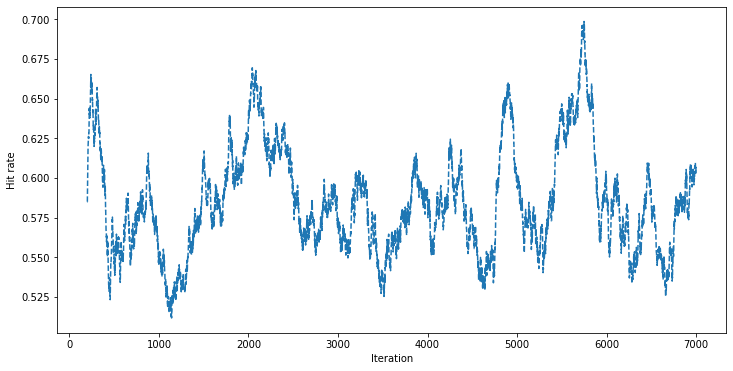

In [16]:
import matplotlib.pyplot as plt
stats = pd.Series(hit_rates)
plt.figure(figsize=(12,6))
plt.plot(stats.index, stats.rolling(200).mean(), "--")
plt.xlabel('Iteration')
plt.ylabel('Hit rate')

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(jester_data)
kmeans = KMeans(n_clusters=5, random_state=0).fit(scaler.transform(jester_data))
contexts = pd.Series(kmeans.labels_, index=jester_data.index)

In [20]:
independent_bandits = IndependentBandits(
    num_arms=jester_data.shape[1],
    num_ranks=10,
    bandit_class=DirichletThompsonSampling
)

In [24]:
hit_rates = []
for _ in trange(1, num_steps+1):
    # pick a user choices at random
    random_user = jester_data.sample().iloc[0, :]
    context = {"previous_action": contexts.loc[random_user.name]}
    selected_items = set(independent_bandits.choose(
        context=context
    ))
    ground_truth = set(random_user[random_user == 1].index)
    hit_rate = len(ground_truth.intersection(selected_items)) / len(ground_truth)
    feedback_list = [1.0 if item in ground_truth else 0.0 for item in selected_items]
    independent_bandits.update(selected_items, feedback_list, context=context)
    hit_rates.append(hit_rate)

100%|██████████| 7000/7000 [00:54<00:00, 128.51it/s]


Text(0, 0.5, 'Hit rate')

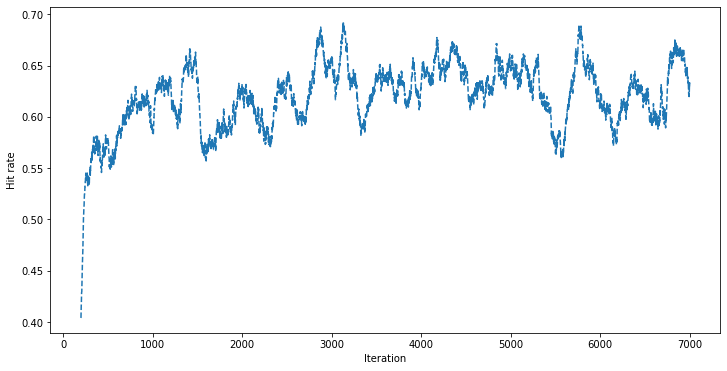

In [25]:
stats = pd.Series(hit_rates)
plt.figure(figsize=(12,6))
plt.plot(stats.index, stats.rolling(200).mean(), "--")
plt.xlabel('Iteration')
plt.ylabel('Hit rate')